<a href="https://colab.research.google.com/github/azzavour/UAS_Machine-Learning_Sensor_Temperature_Prediction/blob/main/UAS_Machine_Learning_Sensor_Temperature_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Impor pustaka dasar untuk manipulasi data dan operasi numerik
import pandas as pd
import numpy as np

# Impor pustaka untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Impor pustaka untuk machine learning
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Impor pustaka untuk mengunduh data
import os
import requests

# Mengatur gaya visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print("Semua pustaka berhasil diimpor!")

Semua pustaka berhasil diimpor!


In [2]:
# URL dari file data utama dan lokasi sensor
data_url = "https://db.csail.mit.edu/labdata/data.txt.gz"
locs_url = "https://db.csail.mit.edu/labdata/mote_locs.txt"

# Nama file lokal
data_filename = "data.txt.gz"
locs_filename = "mote_locs.txt"

# Fungsi untuk mengunduh file
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Mengunduh {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print("Unduhan selesai.")
    else:
        print(f"{filename} sudah ada.")

# Unduh kedua file
download_file(data_url, data_filename)
download_file(locs_url, locs_filename)

# --- Memuat Data ke dalam DataFrame Pandas ---

# Tentukan nama kolom berdasarkan dokumentasi dataset
columns = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Muat data utama
# Data dipisahkan oleh spasi, jadi kita gunakan sep='\s+'
# File dikompresi dengan gzip, jadi kita gunakan compression='gzip'
try:
    df = pd.read_csv(data_filename, sep='\s+', header=None, names=columns, compression='gzip')
    print("Data utama berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat data: {e}")
    # Jika ada error, coba parsing dengan cara yang lebih robust
    # Ini terkadang diperlukan jika ada baris yang formatnya tidak konsisten
    with open(data_filename.replace('.gz', ''), 'r') as f:
        lines = f.readlines()
    data = [line.strip().split() for line in lines if len(line.strip().split()) >= 7]
    df = pd.DataFrame(data)
    # Sesuaikan nama kolom jika jumlahnya berbeda
    df = df.iloc[:, :len(columns)]
    df.columns = columns

# Muat data lokasi sensor
locs_df = pd.read_csv(locs_filename, sep='\s+', header=None, names=['moteid', 'x', 'y'])
print("Data lokasi sensor berhasil dimuat.")

# Tampilkan 5 baris pertama dari setiap dataframe untuk verifikasi
print("\nContoh Data Sensor:")
print(df.head())

print("\nContoh Data Lokasi Sensor:")
print(locs_df.head())

Mengunduh data.txt.gz...
Unduhan selesai.
Mengunduh mote_locs.txt...
Unduhan selesai.
Data utama berhasil dimuat.
Data lokasi sensor berhasil dimuat.

Contoh Data Sensor:
         date             time  epoch  moteid  temperature  humidity  light  \
0  2004-03-31  03:38:15.757551      2     1.0     122.1530  -3.91901  11.04   
1  2004-02-28   00:59:16.02785      3     1.0      19.9884  37.09330  45.08   
2  2004-02-28   01:03:16.33393     11     1.0      19.3024  38.46290  45.08   
3  2004-02-28  01:06:16.013453     17     1.0      19.1652  38.80390  45.08   
4  2004-02-28  01:06:46.778088     18     1.0      19.1750  38.83790  45.08   

   voltage  
0  2.03397  
1  2.69964  
2  2.68742  
3  2.68742  
4  2.69964  

Contoh Data Lokasi Sensor:
   moteid     x   y
0       1  21.5  23
1       2  24.5  20
2       3  19.5  19
3       4  22.5  15
4       5  24.5  12


In [3]:
# --- Prapemrosesan Data ---

# 1. Gabungkan kolom 'date' dan 'time' menjadi satu kolom datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')

# 2. Hapus baris yang datetime-nya tidak valid
df.dropna(subset=['datetime'], inplace=True)

# 3. Hapus kolom 'date' dan 'time' yang sudah tidak diperlukan
df.drop(['date', 'time'], axis=1, inplace=True)

# 4. Konversi tipe data ke numerik, paksa error menjadi NaN (Not a Number)
for col in ['temperature', 'humidity', 'light', 'voltage']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Filter data yang tidak realistis (berdasarkan dokumentasi dan akal sehat)
df = df[df['temperature'] > 0]
df = df[df['humidity'] > 0]
df = df[df['light'] >= 0]
df = df[df['voltage'] > 2.0]

# 6. Urutkan data berdasarkan moteid dan datetime
df.sort_values(by=['moteid', 'datetime'], inplace=True)

# 7. Tangani nilai yang hilang (missing values) dengan interpolasi
# Interpolasi adalah cara cerdas untuk mengisi data deret waktu yang hilang
df[['temperature', 'humidity', 'light', 'voltage']] = df.groupby('moteid')[['temperature', 'humidity', 'light', 'voltage']].transform(
    lambda x: x.interpolate(method='linear')
)
# Hapus sisa NaN yang mungkin masih ada di awal atau akhir grup
df.dropna(inplace=True)

# 8. Gabungkan data utama dengan data lokasi sensor
df = pd.merge(df, locs_df, on='moteid')

print("Pembersihan dan prapemrosesan data selesai.")
print("\nInfo DataFrame setelah dibersihkan:")
df.info()
print("\nContoh Data setelah dibersihkan dan digabung:")
print(df.head())

Pembersihan dan prapemrosesan data selesai.

Info DataFrame setelah dibersihkan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922254 entries, 0 to 1922253
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   epoch        int64         
 1   moteid       float64       
 2   temperature  float64       
 3   humidity     float64       
 4   light        float64       
 5   voltage      float64       
 6   datetime     datetime64[ns]
 7   x            float64       
 8   y            int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 132.0 MB

Contoh Data setelah dibersihkan dan digabung:
   epoch  moteid  temperature  humidity  light  voltage  \
0      3     1.0      19.9884   37.0933  45.08  2.69964   
1     11     1.0      19.3024   38.4629  45.08  2.68742   
2     17     1.0      19.1652   38.8039  45.08  2.68742   
3     18     1.0      19.1750   38.8379  45.08  2.69964   
4     22     1.0      19.1456  

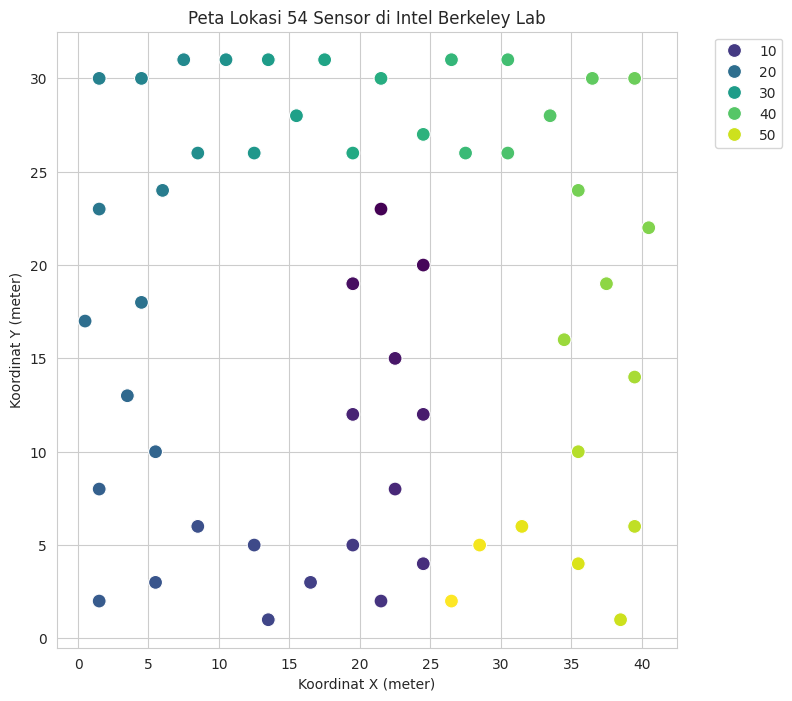

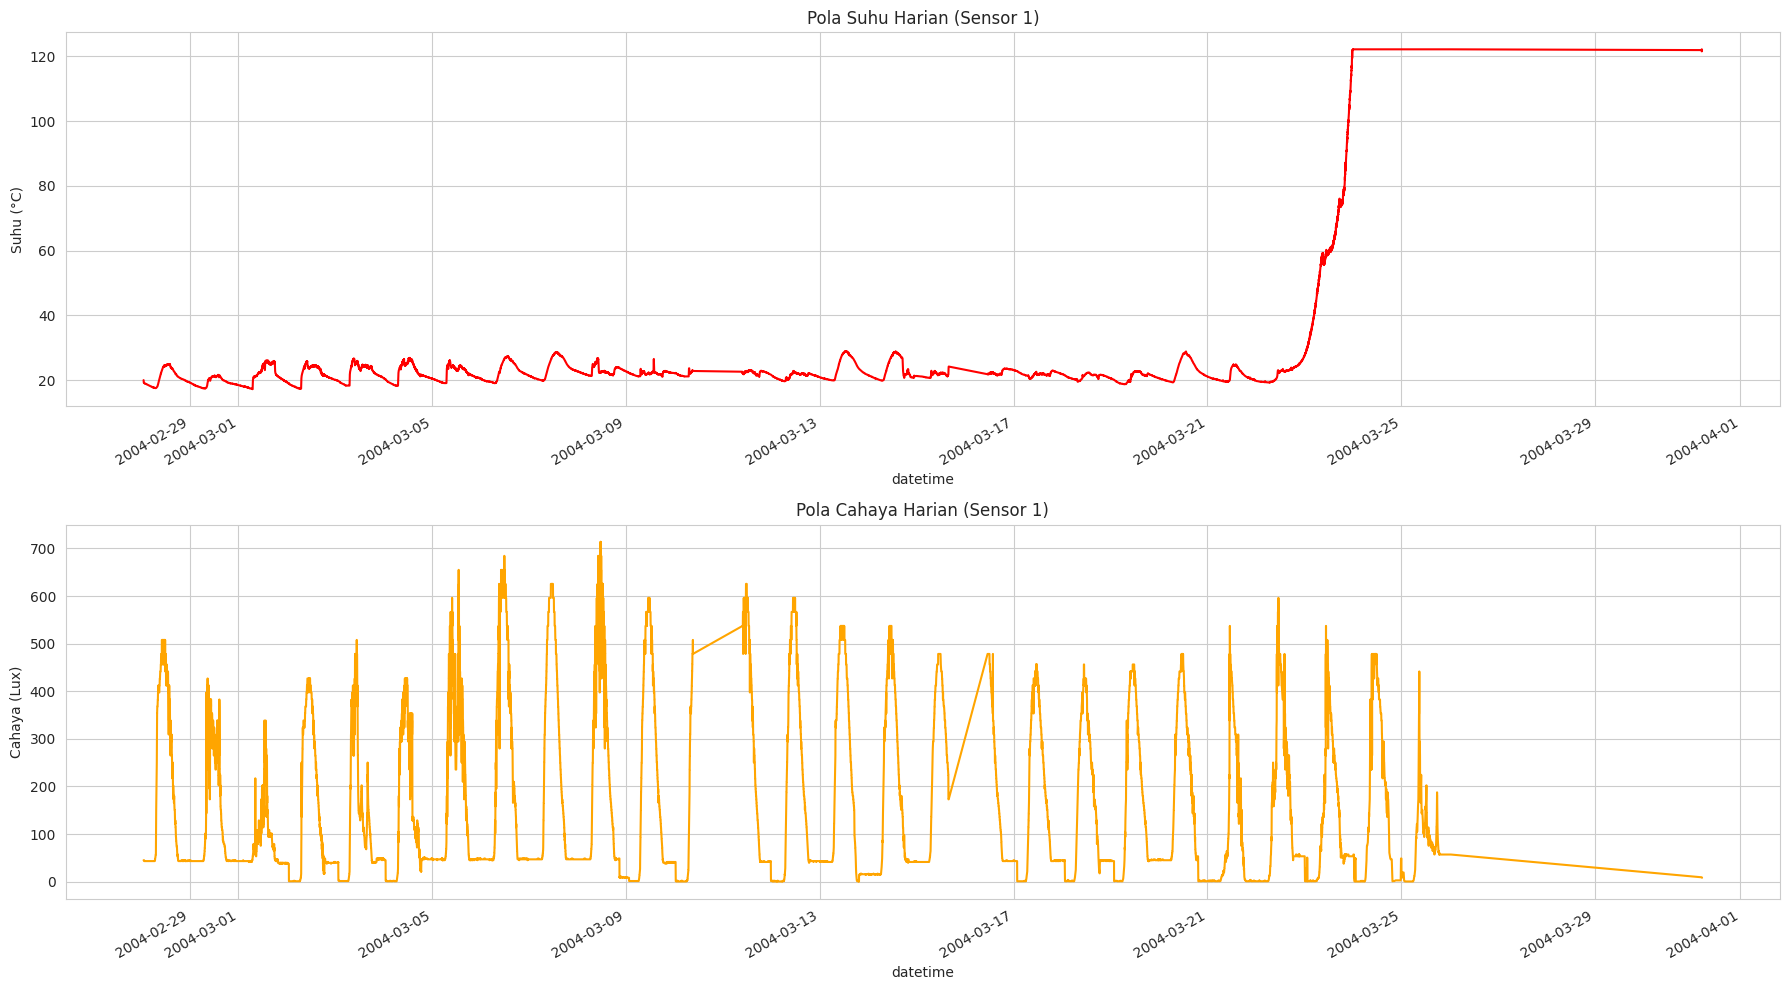

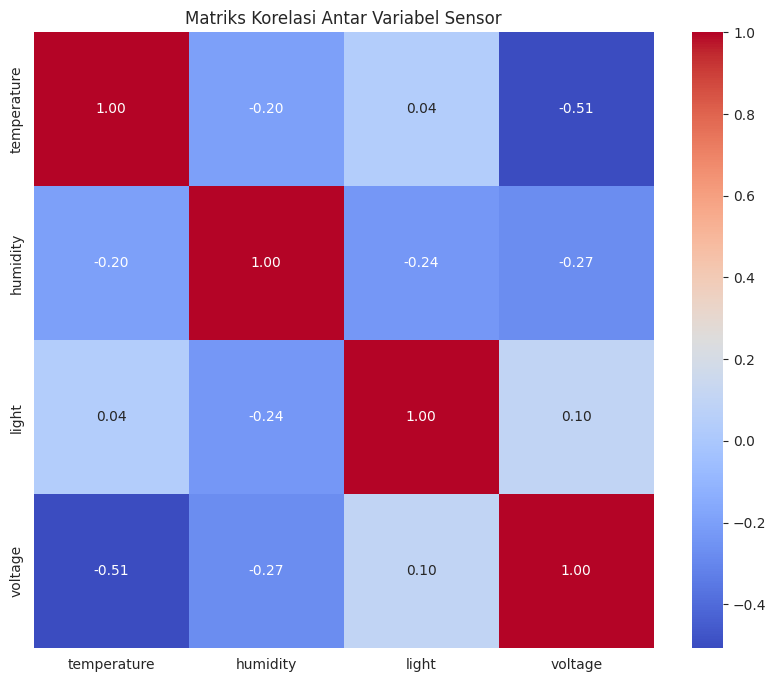

In [4]:
# 1. Visualisasi Lokasi Sensor
plt.figure(figsize=(8, 8))
sns.scatterplot(data=locs_df, x='x', y='y', hue='moteid', palette='viridis', s=100)
plt.title('Peta Lokasi 54 Sensor di Intel Berkeley Lab')
plt.xlabel('Koordinat X (meter)')
plt.ylabel('Koordinat Y (meter)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 2. Visualisasi Deret Waktu untuk Satu Sensor
# Kita pilih sensor 1 untuk melihat polanya
sensor_1_df = df[df['moteid'] == 1].set_index('datetime')

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
sensor_1_df['temperature'].plot(title='Pola Suhu Harian (Sensor 1)', color='red')
plt.ylabel('Suhu (°C)')

plt.subplot(2, 1, 2)
sensor_1_df['light'].plot(title='Pola Cahaya Harian (Sensor 1)', color='orange')
plt.ylabel('Cahaya (Lux)')
plt.tight_layout()
plt.show()
# Terlihat jelas pola harian (diurnal) pada suhu dan cahaya, yang menandakan adanya musim (seasonality).

# 3. Matriks Korelasi
plt.figure(figsize=(10, 8))
correlation_matrix = df[['temperature', 'humidity', 'light', 'voltage']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi Antar Variabel Sensor')
plt.show()
# Seperti yang disebutkan di dokumentasi, ada korelasi kuat antara tegangan (voltage) dan suhu (temperature).

In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb

print("Memulai Langkah 5: Rekayasa Fitur...")

df_model = df.copy()

# Fitur waktu
df_model['hour'] = df_model['datetime'].dt.hour
df_model['dayofweek'] = df_model['datetime'].dt.dayofweek
df_model['dayofyear'] = df_model['datetime'].dt.dayofyear
df_model['weekofyear'] = df_model['datetime'].dt.isocalendar().week.astype(int)

# Fitur lag
lags = [1, 2, 3, 4, 5]
for lag in lags:
    df_model[f'temp_lag_{lag}'] = df_model.groupby('moteid')['temperature'].shift(lag)
    df_model[f'humidity_lag_{lag}'] = df_model.groupby('moteid')['humidity'].shift(lag)
    df_model[f'light_lag_{lag}'] = df_model.groupby('moteid')['light'].shift(lag)

# Fitur rolling
window_sizes = [4, 5, 6]
for window in window_sizes:
    df_model[f'temp_roll_mean_{window}'] = df_model.groupby('moteid')['temperature'].transform(
        lambda x: x.shift(1).rolling(window).mean()
    )
    df_model[f'temp_roll_std_{window}'] = df_model.groupby('moteid')['temperature'].transform(
        lambda x: x.shift(1).rolling(window).std()
    )

# Hapus baris yang mengandung NaN
df_model.dropna(inplace=True)

print("Rekayasa fitur selesai.")
print(f"Ukuran data setelah rekayasa fitur dan pembersihan: {df_model.shape}")

print("\nMemulai Langkah 6: Persiapan dan Pelatihan Model...")

TARGET = 'temperature'

# Tentukan fitur (X) dan target (y)
cols_to_drop = ['datetime', 'epoch', 'temperature']
features = [col for col in df_model.columns if col not in cols_to_drop]

X = df_model[features]
y = df_model[TARGET]  # hanya 1 kolom target

# Split train-test
train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Ukuran data Latih (Train): {X_train.shape}")
print(f"Ukuran data Uji (Test): {X_test.shape}")

print("\nMemulai pelatihan model LightGBM...")

lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    seed=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # sesuai format (X, y)
    eval_metric='l1',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

print("\nPelatihan model selesai.")


Memulai Langkah 5: Rekayasa Fitur...
Rekayasa fitur selesai.
Ukuran data setelah rekayasa fitur dan pembersihan: (1921942, 34)

Memulai Langkah 6: Persiapan dan Pelatihan Model...
Ukuran data Latih (Train): (1537553, 31)
Ukuran data Uji (Test): (384389, 31)

Memulai pelatihan model LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5353
[LightGBM] [Info] Number of data points in the train set: 1537553, number of used features: 31
[LightGBM] [Info] Start training from score 22.144400

Pelatihan model selesai.


Mean Absolute Error (MAE) pada data uji: 0.0637
Root Mean Squared Error (RMSE) pada data uji: 0.3658
Sebagai perbandingan, rata-rata suhu pada data uji adalah: 24.8169 °C

Interpretasi: Rata-rata kesalahan prediksi model kita hanya sekitar 0.06 derajat Celsius, yang menunjukkan performa sangat baik.
Sensor yang tersedia di data uji: [44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]


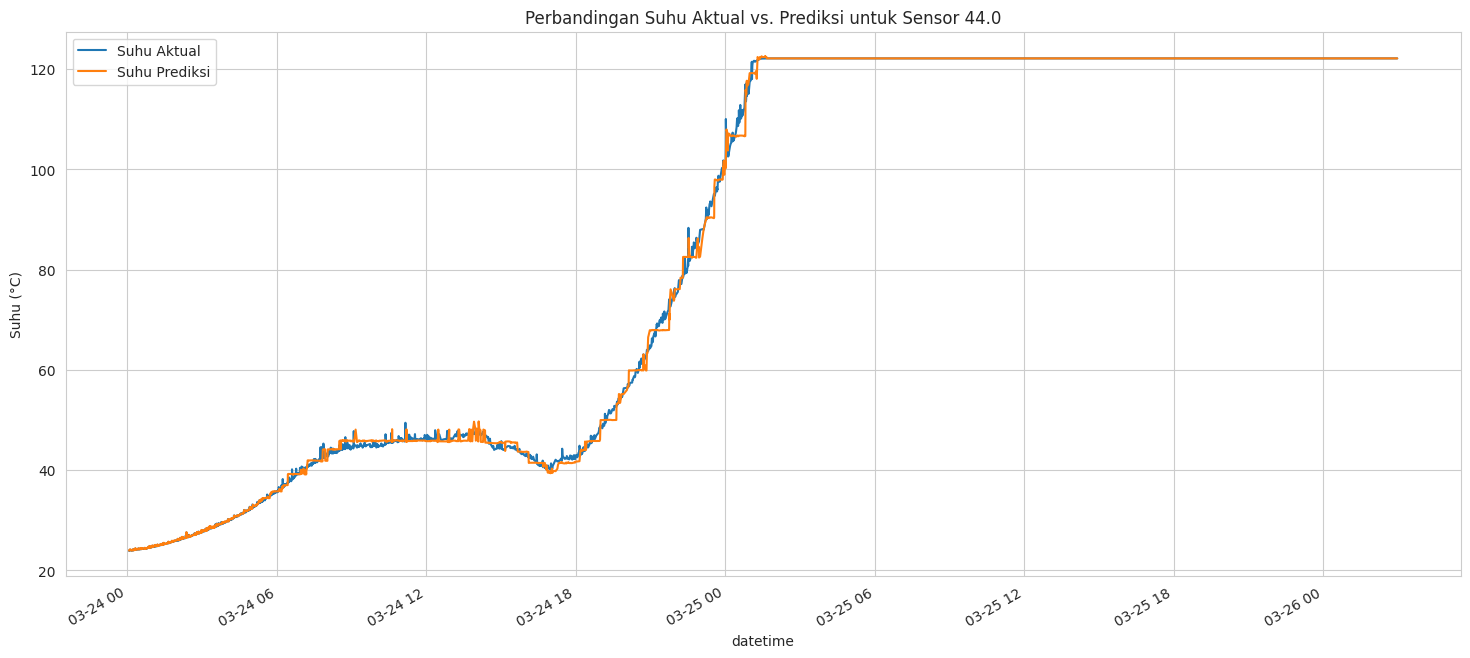

<Figure size 1000x1200 with 0 Axes>

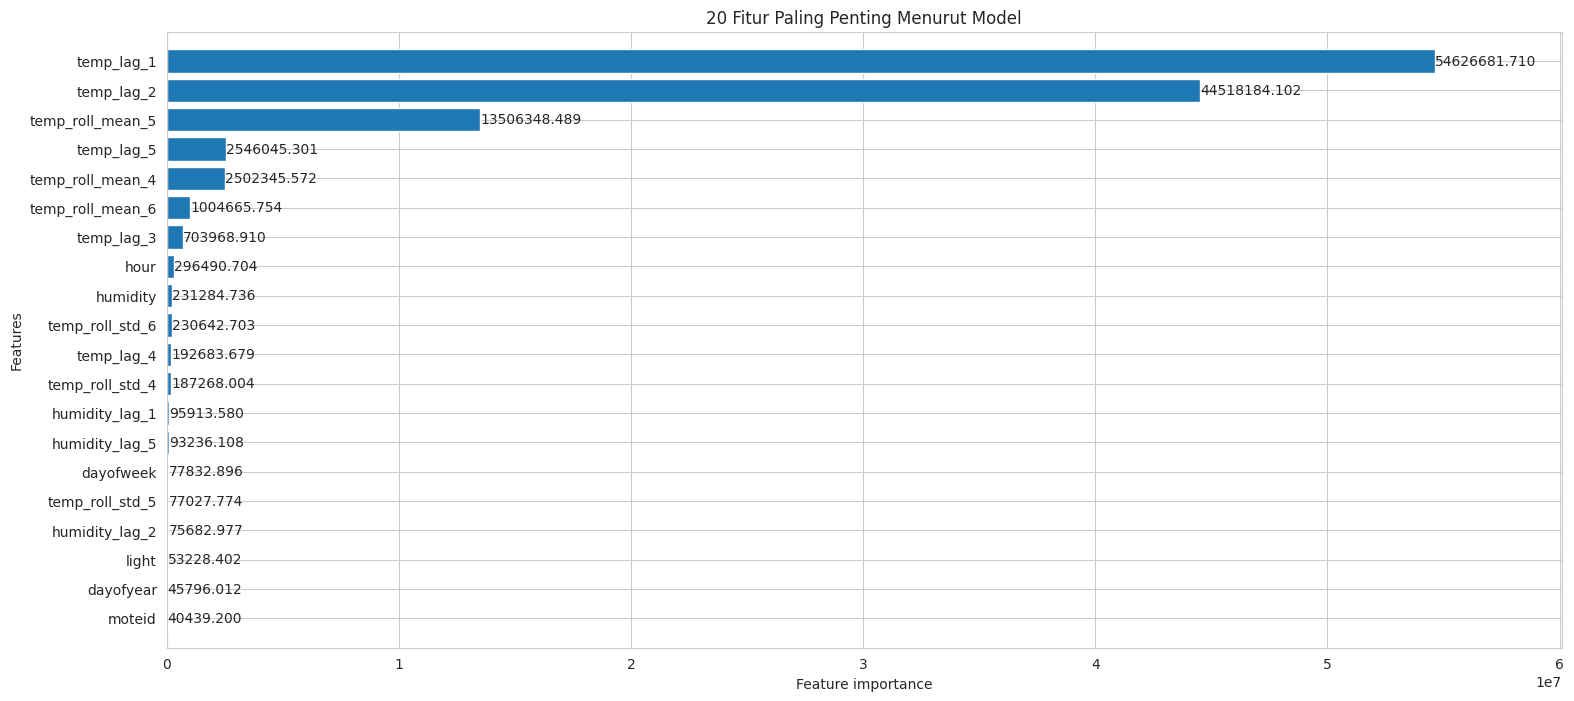

In [26]:
# =============================
# 1. Impor pustaka evaluasi & visualisasi
# =============================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb

# Gaya visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# =============================
# 2. Membuat prediksi pada data uji
# =============================
y_pred = lgbm.predict(X_test)

# =============================
# 3. Menghitung metrik evaluasi
# =============================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE) pada data uji: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) pada data uji: {rmse:.4f}")
print(f"Sebagai perbandingan, rata-rata suhu pada data uji adalah: {y_test.mean():.4f} °C")
print("\nInterpretasi: Rata-rata kesalahan prediksi model kita hanya sekitar",
      f"{mae:.2f} derajat Celsius, yang menunjukkan performa sangat baik.")

# =============================
# 4. Siapkan DataFrame untuk plotting
# =============================
test_df = df_model.iloc[train_size:].copy()  # ambil data uji
results_df = pd.DataFrame({
    'datetime': pd.to_datetime(test_df['datetime']),  # pastikan format datetime
    'moteid': test_df['moteid'],
    'Suhu Aktual': y_test.values,
    'Suhu Prediksi': y_pred
})

# =============================
# 5. Cek sensor yang ada
# =============================
available_sensors = results_df['moteid'].unique()
print("Sensor yang tersedia di data uji:", available_sensors)

# Pilih sensor pertama yang ada
sensor_id = available_sensors[0]

# Filter data untuk sensor tersebut
sensor_results = results_df[results_df['moteid'] == sensor_id].set_index('datetime')

# =============================
# 6. Plot Suhu Aktual vs Prediksi
# =============================
sensor_results[['Suhu Aktual', 'Suhu Prediksi']].plot()
plt.title(f'Perbandingan Suhu Aktual vs. Prediksi untuk Sensor {sensor_id}')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.show()

# =============================
# 7. Plot Tingkat Kepentingan Fitur
# =============================
plt.figure(figsize=(10, 12))
lgb.plot_importance(lgbm, height=0.8, max_num_features=20, importance_type='gain')
plt.title('20 Fitur Paling Penting Menurut Model')
plt.show()
